# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [35]:
#def P1(num_examples=5):
    ### STUDENT START ###
def find_label(labels_data, num_labels=5):
    label_names = newsgroups_train.target_names
    label_indexes = labels_data[:num_labels]
    text_labels = []
    for index in label_indexes:
        text_labels.append(label_names[index])
    return text_labels

five_labels = find_label(train_labels)
print("First message: {m}\n label: {l} \n".format(m=train_data[0], l=five_labels[0]))
print("Second message: {m}\n label: {l} \n".format(m=train_data[1], l=five_labels[1]))
print("Third message: {m}\n label: {l} \n".format(m=train_data[2], l=five_labels[2]))
print("Fourth message: {m}\n label: {l} \n".format(m=train_data[3], l=five_labels[3]))
print("Fifth message: {m}\n label: {l} \n".format(m=train_data[4], l=five_labels[4]))
    ### STUDENT END ###

#P1(5)

First message: Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
 label: comp.graphics 

Second message: 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such evil corruption
for centuries.
 label

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [36]:
#def P2():
    ### STUDENT START ###
#Question a: Use CountVectorizer on the training data and inspect the vocabulary and sparse matrix
vectorizer = CountVectorizer()
train_cv = vectorizer.fit_transform(train_data)
num_nonzero = []
for i in range(train_cv.shape[0]):
    k = train_cv[i].nnz
    num_nonzero.append(k)

print("The size of the vocabulary is %s." %(train_cv.shape[1]))
print("The average number of non-zero features per example is %s." %(round(np.average(num_nonzero),2)))
print("The proportion of entries in the matrix that are non-zero is {s}%.".format(
    s= round(train_cv.nnz/(train_cv.shape[0]*train_cv.shape[1])*100,2)))
print("The 0th and last feature names are: {a} and {b}.".format(
    a=vectorizer.get_feature_names()[0], b=vectorizer.get_feature_names()[-1]))

#Question b: Use a new vocabulary of four features and inspect the new sparse matrix 
vectorizer2 = CountVectorizer(vocabulary = ["atheism", "graphics", "space", "religion"])
train_cv2 = vectorizer2.transform(train_data)
num_nonzero2 = []
for i in range(train_cv2.shape[0]):
    k = train_cv2[i].nnz
    num_nonzero2.append(k)

print("The average number of nonzero features with the new vocabulary is %s." %(round(np.average(num_nonzero2),2)))

#Question c: Use a new vocabulary of bigram and trigram character features and inspect the vocabulary
vectorizer3 = CountVectorizer(analyzer='char', ngram_range=(2, 3))
train_cv3 = vectorizer3.fit_transform(train_data)
print("The size of the vocabulary using bigram and trigram features is %s." %len(vectorizer3.vocabulary_))

#Question d: Run CountVectorizer again but disregard words that appear less than 10 times
vectorizer4 = CountVectorizer(min_df = 10)
train_cv4 = vectorizer4.fit_transform(train_data)
print("The size of the vocabulary without words appearing less than 10 times is %s." %len(vectorizer4.vocabulary_))

#Question e: Run CountVectorizer on the dev data and compare the size of the vocabulary to that of the training data
vectorizer5 = CountVectorizer()
unique_dev_cv = vectorizer5.fit_transform(dev_data)
print("The fraction of words missing in the dev data vocabulary in relation to the train data vocabulary is %s." %(
    round(len(vectorizer5.vocabulary_)/len(vectorizer.vocabulary_),3)))
    ### STUDENT END ###

#P2()

The size of the vocabulary is 26879.
The average number of non-zero features per example is 96.71.
The proportion of entries in the matrix that are non-zero is 0.36%.
The 0th and last feature names are: 00 and zyxel.
The average number of nonzero features with the new vocabulary is 0.27.
The size of the vocabulary using bigram and trigram features is 35478.
The size of the vocabulary without words appearing less than 10 times is 3064.
The fraction of words missing in the dev data vocabulary in relation to the train data vocabulary is 0.604.


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [14]:
#def P3():
    ### STUDENT START ###
#Use CountVectorizer with default options to turn training data text into feature vectors
vectorizer = CountVectorizer()
train_cv = vectorizer.fit_transform(train_data)
dev_cv = vectorizer.transform(dev_data)

#Build a knn classifier and find the optimal value for k
for i in range(1, 11):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(train_cv, train_labels)
    dev_pred = knn.predict(dev_cv)
    f1_score = round(metrics.f1_score(dev_labels, dev_pred, average = 'weighted'),4)
    print("The f1 score of the model with {a} neighbors is: {b}".format(a = i, b = f1_score))

print("\n")
#Build a MultinomialNB classifier and find the optimal value for alpha
alpha= [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]
for a in alpha:
    mnb = MultinomialNB(alpha = a)
    mnb.fit(train_cv, train_labels)
    dev_pred = mnb.predict(dev_cv)
    f1_score = round(metrics.f1_score(dev_labels, dev_pred, average = 'weighted'),4)
    print("The f1 score of the model with alpha = {c} is: {d}".format(c = a, d = f1_score))
    
print("\n")   
#Build a LogisticRegression model and find the optimal value for C
c_values= [0.001, 0.01, 0.15, 0.5, 1.0, 2.0, 10.0, 100.0, 1000.0]
logr_coef = []
for c in c_values:
    logr = LogisticRegression(penalty = 'l2', C = c, solver = 'newton-cg', multi_class = 'auto')
    logr.fit(train_cv, train_labels)
    dev_pred = logr.predict(dev_cv)
    f1_score = round(metrics.f1_score(dev_labels, dev_pred, average = 'weighted'),4)
    logr_coef.append(logr.coef_)
    print("The f1 score of the model with c = {e} is: {f}".format(e = c, f = f1_score))
    
#Calculate the sum of the squared weights for each class and value of c
#to examine the relationship between C and the sum of the squared weights
square_sum = []
for i in range(9):
    square_weight = (logr_coef[i])**2
    for array in square_weight:
        square_sum.append(sum(array))
    
print("\nThe sum of the squared weights for each class for each value of C is: \n %s" %np.array(square_sum))
    ### STUDENT END ###

#P3()

The f1 score of the model with 1 neighbors is: 0.3805
The f1 score of the model with 2 neighbors is: 0.3805
The f1 score of the model with 3 neighbors is: 0.4084
The f1 score of the model with 4 neighbors is: 0.4031
The f1 score of the model with 5 neighbors is: 0.4288
The f1 score of the model with 6 neighbors is: 0.4467
The f1 score of the model with 7 neighbors is: 0.4505
The f1 score of the model with 8 neighbors is: 0.447
The f1 score of the model with 9 neighbors is: 0.4366
The f1 score of the model with 10 neighbors is: 0.4279


The f1 score of the model with alpha = 1e-10 is: 0.7472
The f1 score of the model with alpha = 0.0001 is: 0.7628
The f1 score of the model with alpha = 0.001 is: 0.7703
The f1 score of the model with alpha = 0.01 is: 0.7752
The f1 score of the model with alpha = 0.1 is: 0.7903
The f1 score of the model with alpha = 0.5 is: 0.7863
The f1 score of the model with alpha = 1.0 is: 0.7777
The f1 score of the model with alpha = 2.0 is: 0.769
The f1 score of the

ANSWER:
* In this case, the KNN model doesn't work well, because looking at the vocabulary for CountVectorizer, there are plenty of words that would overlap between the different genres, such as 'hello' and 'good.' Since the model only looks at the training data with the closest number of features as the dev data, the KNN model doesn't work well.
* Logistic regression doesn't work as well as NaiveBayes in this case because of the relatively small size of the training data. Because Naive Bayes converges faster, it looks like Naive Bayes does better in this case. This stems from Naive Bayes' assumption that all features are conditionally independent, allowing for more bias in the model.
* The relationship between the value of C and the sum of the squared weights for each class is dirrectly proportional. As the value of C increases, the sum of the squared weights increases as well.

### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

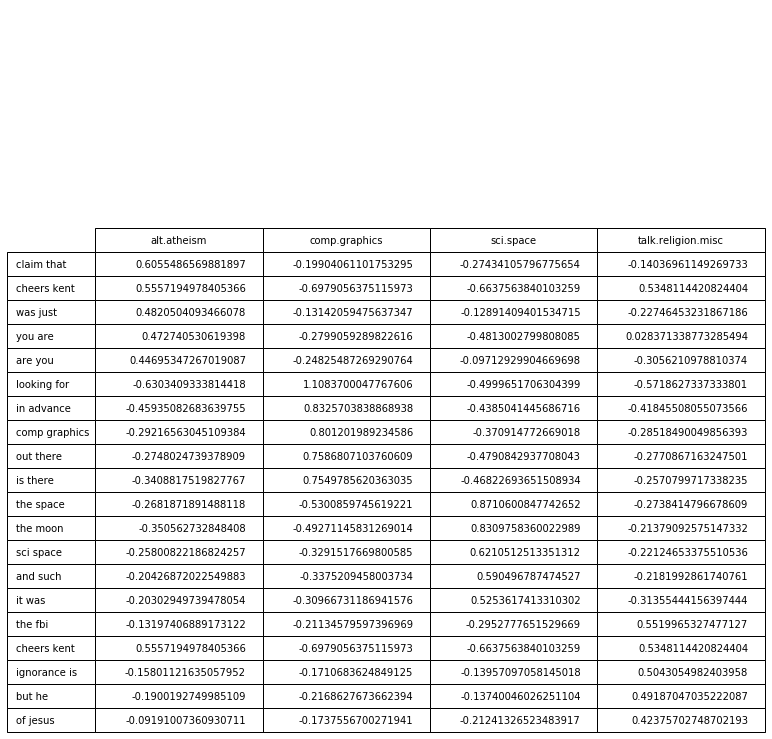

In [16]:
#def P4():
    ### STUDENT START ###
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2))
train_bigram = bigram_vectorizer.fit_transform(train_data)
dev_bigram = bigram_vectorizer.transform(dev_data)

bigram_logr = LogisticRegression(penalty = 'l2', C = 0.5, solver = 'liblinear', multi_class = 'auto')
bigram_logr.fit(train_bigram, train_labels)
bigram_weights = bigram_logr.coef_
bigram_indexes = []
for i in range(4):
    sort_desc = np.argsort(bigram_weights)[i][::-1]
    bigram_indexes.append(sort_desc[:5])
bigram_indexes = np.concatenate(bigram_indexes)

bigram_features = np.take(bigram_vectorizer.get_feature_names(), bigram_indexes)
top_bigram_weights = [np.take(bigram_weights[i], bigram_indexes) for i in range(4)]
top_bigram_weights = np.column_stack(top_bigram_weights)

table2 = plt.table(cellText = top_bigram_weights,
                 colLabels = newsgroups_train.target_names,
                 rowLabels = bigram_features)

table2.scale(2,2)
plt.axis("off")
plt.grid(False)
plt.show()
    ### STUDENT END ###

#P4()

ANSWER: The most surprising bigram features to me are 'cheers kent', which appears twice for both atheism and religion, and 'the fbi.' It's not clear what the connections are to atheism and religion, respectively. But looking at the other bigram features, there are many that don't distinctively sound like a certain genre, such as 'you are,' 'and such,' 'is there,' it was,' etc.

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [37]:
#def better_preprocessor(s):
    ### STUDENT START ###
def empty_preprocessor(s):
    return s

porter_stemmer = nltk.stem.PorterStemmer()
def better_preprocessor(s):
    lower_case = s.lower() #lower case all letters
    num_to_pound = re.sub(r'[0-9]+','#', lower_case) #Turn all sequences of digits to #
    no_special = re.sub("\\W"," ",num_to_pound) # remove special chars
    #Remove stop words
    stopwords=['this','that','and','a','we','it','to','is','of','up','he', 'she', 'they', 'be', 'are', 'but', 'or',
               'for', 'us', 'me', 'him', 'his', 'her', 'hers', 'my', 'mine', 'their', 'theirs', 'our', 'ours', 
               'hi', 'hey', 'you', 'yours', 'your', 'was', 'were', 've', 'under', 'while', 'who', 'too', 'why']
    words = no_special.split(" ")
    no_stop_words = []
    for w in words:
        if w not in stopwords:
            no_stop_words.append(w)
    new_text = ' '.join(no_stop_words)
    #Stem words
    words = new_text.split()
    stemmed_text = [porter_stemmer.stem(word=word) for word in words]
    stemmed_text = ' '.join(stemmed_text)
    no_new_line = stemmed_text.replace('\n', ' ')
    return no_new_line

    ### STUDENT END ###

#def P5():
    ### STUDENT START ###
empty_cv = CountVectorizer(preprocessor = empty_preprocessor)
empty_train = empty_cv.fit_transform(train_data)
empty_dev = empty_cv.transform(dev_data)

#Conduct a logistic regression using the vocabulary given by the empty_preprocessor
empty_logr = LogisticRegression(penalty = 'l2', C = 0.15, solver = 'liblinear', multi_class = 'auto')
empty_logr.fit(empty_train, train_labels)
empty_pred = empty_logr.predict(empty_dev)
empty_f1 = round(metrics.f1_score(dev_labels, empty_pred, average = 'weighted'),4)
print("Without pre-processing the data, the f1 score is %s." %empty_f1)
print("The size of the unprocessed dictionary is %s." %empty_train.shape[1])

#Create a vocabulary using the better_preprocessor function
better_cv = CountVectorizer(preprocessor = better_preprocessor)
better_train = better_cv.fit_transform(train_data)
better_dev = better_cv.transform(dev_data)

#Conduct a logistic regression using the vocabulary given by the better_preprocessor
better_logr = LogisticRegression(penalty = 'l2', C = 0.15, solver = 'liblinear', multi_class = 'auto')
better_logr.fit(better_train, train_labels)
better_pred = better_logr.predict(better_dev)
better_f1 = round(metrics.f1_score(dev_labels, better_pred, average = 'weighted'),4)
print("With pre-processing the data, the f1 score is %s, improving the score by 3 points." %better_f1)
print("The size of the pre-processed dictionary is %s." %better_train.shape[1])

percent_change = ((empty_train.shape[1]-better_train.shape[1])/empty_train.shape[1])*100
print("The vocabulary decreased by {d}% using the preprocessor.".format(d=round(percent_change,4)))
    
    ### STUDENT END ###

#P5()

Without pre-processing the data, the f1 score is 0.7041.
The size of the unprocessed dictionary is 33291.
With pre-processing the data, the f1 score is 0.731, improving the score by 3 points.
The size of the pre-processed dictionary is 17206.
The vocabulary decreased by 48.3164% using the preprocessor.


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

In [22]:
#def P6():
    # Keep this random seed here to make comparison easier.
np.random.seed(0)
    
    ### STUDENT START ###
vectorizer = CountVectorizer()
train_cv = vectorizer.fit_transform(train_data)
dev_cv = vectorizer.transform(dev_data)

c_values= [0.001, 0.01, 0.15, 0.5, 1.0, 10.0, 100.0]
pruned_f1_scores = []
vocab_sizes = []
for c in c_values:
    l1_logr = LogisticRegression(penalty = 'l1', C = c, solver = 'liblinear', multi_class = 'auto', tol=0.015)
    l1_logr.fit(train_cv, train_labels)
    #Find indexes of nonzero features for model using l1 regularization
    l1_nonzero_indexes = np.array([])
    for i in range(len(l1_logr.coef_)):
        nonzero = np.nonzero(l1_logr.coef_[i])
        l1_nonzero_indexes = np.append(l1_nonzero_indexes, nonzero)
    l1_nonzero_indexes = np.unique(l1_nonzero_indexes)
    size = len(l1_nonzero_indexes)
    vocab_sizes.append(size)

    #Keep features from vocabulary based off l1_nonzero_indexes
    pruned_vocab = [vectorizer.get_feature_names()[int(index)] for index in l1_nonzero_indexes]
    pruned_cv = CountVectorizer(vocabulary = pruned_vocab)
    pruned_train = pruned_cv.transform(train_data)
    pruned_dev = pruned_cv.transform(dev_data)

    #Fit a model with l2 regularization using the pruned vocabulary
    pruned_logr = LogisticRegression(penalty = 'l2', C = 0.5, solver = 'liblinear', multi_class = 'auto', tol=0.015)
    pruned_logr.fit(pruned_train, train_labels)
    pruned_pred = pruned_logr.predict(pruned_dev)
    pruned_f1 = round(metrics.f1_score(dev_labels, pruned_pred, average = 'weighted'),4)
    print("Using a strength of {s} for the L1 model, the vocabulary size is {t}, and the f1_score is {u}".format(
    s= c, t = len(l1_nonzero_indexes), u = pruned_f1))
    pruned_f1_scores.append(pruned_f1)
    ### STUDENT END ###

#P6()

Using a strength of 0.001 for the L1 model, the vocabulary size is 3, and the f1_score is 0.3336
Using a strength of 0.01 for the L1 model, the vocabulary size is 17, and the f1_score is 0.4639
Using a strength of 0.15 for the L1 model, the vocabulary size is 298, and the f1_score is 0.6774
Using a strength of 0.5 for the L1 model, the vocabulary size is 778, and the f1_score is 0.6697
Using a strength of 1.0 for the L1 model, the vocabulary size is 1162, and the f1_score is 0.6797
Using a strength of 10.0 for the L1 model, the vocabulary size is 3320, and the f1_score is 0.6934
Using a strength of 100.0 for the L1 model, the vocabulary size is 7752, and the f1_score is 0.6885


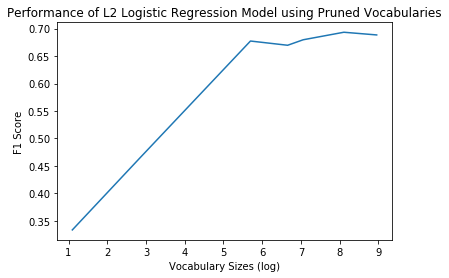

In [34]:
#Take the log of the vocab sizes
log_vocab_sizes = np.log(vocab_sizes)

#Plot the f1 scores against the log vocab sizes
plt.plot(log_vocab_sizes, pruned_f1_scores)
plt.xlabel("Vocabulary Sizes (log)")
plt.ylabel("F1 Score")
plt.title("Performance of L2 Logistic Regression Model using Pruned Vocabularies")
plt.show()

ANSWER: The performance of the models using a reduced vocabulary didn't seem to perform much better compared to the models that used the vocabulary generated by the default parameters of CountVectorizer. The f1 scores for each model, except those with C= 0.001 and 0.01, were around 0.70, which was about the same score for the optimal logistic regression model from part 2.

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [38]:
#def P7():
    ### STUDENT START ###
tfidf = TfidfVectorizer()
train_tfidf = tfidf.fit_transform(train_data)
dev_tfidf = tfidf.transform(dev_data)

tfidf_logr = LogisticRegression(C=100, solver = 'liblinear', multi_class = 'auto')
tfidf_logr.fit(train_tfidf, train_labels)
tfidf_pred = tfidf_logr.predict(dev_tfidf)
tfidf_f1 = round(metrics.f1_score(dev_labels, tfidf_pred, average = 'weighted'),4)
label_prob = tfidf_logr.predict_proba(dev_tfidf)
r_ratio = np.array([])
for i in range(len(dev_labels)):
    ratio = max(label_prob[i])/label_prob[i][dev_labels[i]]
    r_ratio = np.append(r_ratio, ratio)

sorted_r_index = np.argsort(r_ratio)
top3_r_indexes = sorted_r_index[::-1][:3]
print("The f1 score using TfidfVectorizer is %s." %tfidf_f1)
print("\n The document with the highest R value is: \n %s \n" %(dev_data[top3_r_indexes[0]]))
print("The document with the second highest R value is: \n %s \n" %(dev_data[top3_r_indexes[1]]))
print("The document with the third highest R value is: \n %s \n" %(dev_data[top3_r_indexes[2]]))

    ### STUDENT END ###

#P7()

The f1 score using TfidfVectorizer is 0.7598.

 The document with the highest R value is: 
 I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for their time in making copies, or in any way realize a profit
from the use 

ANSWER:
* TfidfVectorizer is different from CountVectorizer in that it looks at each word in the training data and assigns a weight to each word based on how frequently it appears in a given document and across all documents. This means it weights words that are more unique within a corpus of training data more highly for a given label.
* The R-ratio measures how far off the prediction was from the actual value by comparing the maximum likelihood probability that a piece of text is a certain genre and the probability of the correct class. By looking at the ratio, we can estimate how far off the prediction is from the real value.
* The issue with TfidfVectorizer is that it may discount words that appear frequently across different texts for a given subject. Since it calculates a weight for each feature based on the frequency of its appearance in a given dcoument multiplied by the inverse of the frequency the feature appears across all documents, it may not assign a high enough weight to important features that appear frequently in a certain type of text, reducing the accuracy of the model.

### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.